In [2]:

#pip install nltk

In [3]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download ('wordnet')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

import re


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erice\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
df = pd.read_csv(r'C:\Users\erice\projects\ChatGPT-Text-Analysis\data\chatgpt-reddit-comments.csv')
df.shape
df.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


<AxesSubplot:>

Text(0.5, 0, 'SubReddit')

Text(0, 0.5, 'Number of Comments')

Text(0.5, 1.0, 'Data Frequency for SubReddit')

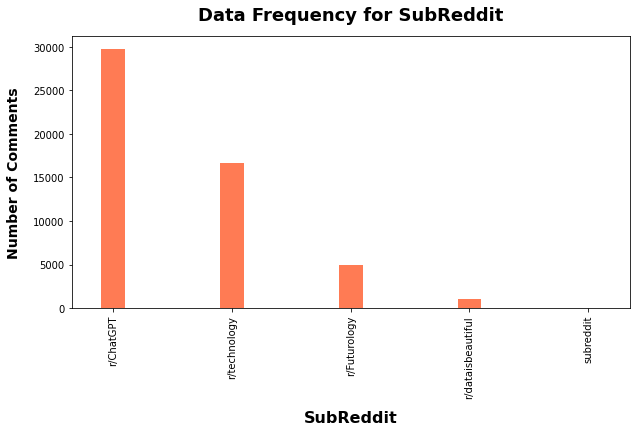

In [5]:
df['subreddit'].value_counts().sort_values(ascending = False).plot(kind='bar', figsize=(10,5), width=0.2, color="#FF7B54")

plt.xlabel("SubReddit", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of Comments", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Data Frequency for SubReddit", fontsize=18,pad=16, fontweight="bold")

plt.show()

In [6]:
#Check for/Remove NULL values
df.dropna(inplace=True)
df.isnull().value_counts()
df.head()

Unnamed: 0  comment_id  comment_parent_id  comment_body  subreddit
False       False       False              False         False        52412
dtype: int64

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [38]:
stop_words = set(stopwords.words('english'))
#stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
def clean_comments(comment):
    #Normalize text
    comment = comment.lower()

    #Remove special characters/URLS and '@' tags and non numbers/letters
    comment = re.sub(r"(@\[A-Za-z0-9]+)|([^A-Za-z])|(\w+:\/\/\S+)|^rt|http.+?", " ", comment)

    #Remove linebreaks
    comment = re.sub(r"\n", " ",comment)
    
    #Remove non-words/single characters
    comment = re.sub(r"(^| ).(( ).)*( |$)", " ", comment)

    #Remove stopwords and lemmatize
    word_tokens = word_tokenize(comment)
    clean_token_list = []
    for word_token in word_tokens:
        if word_token not in stop_words:
            clean_token_list.append(lemmatizer.lemmatize(word_token,pos = 'v'))
    
    clean_comment = " ".join(clean_token_list)
    
    return clean_comment


In [41]:
lemmatizer.lemmatize('automate', pos='n')

'automate'

In [45]:

clean_comments(df.comment_body[52414])

'know refer tos section seem noteworthy'

In [46]:
df.comment_body[52414]

"Don't know what they're referring to in the TOS but these sections seem noteworthy?\n\n* 2(c)\n* 3(c)(d)\n* 5(a)(c)\n* 6(a)\n* 8\n* 9(i)(k)"

In [44]:
cleaned_df = df.copy()
cleaned_df['comment_body'] = df.comment_body.apply(lambda x: clean_comments(x))

In [50]:
# Generating TF-IDF Vector for KMeans from the comment_body
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                ngram_range = (1,3),
                                stop_words = "english"                              
                            )

tf_idf = vectorizer.fit_transform(cleaned_df.comment_body)

In [47]:
from IPython.display import display
cleaned_df

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,cluster
0,0,iztdxuh,t3_zj2aeu,shock days need clickbait,r/ChatGPT,0
1,1,iztn0q0,t3_zj2aeu,angry right waste time read post sub clickbait...,r/ChatGPT,0
2,2,izudrph,t3_zj2aeu,chatgpt karma whore folks think stream think b...,r/ChatGPT,0
3,3,iztfhtb,t3_zj2aeu,work ngl,r/ChatGPT,0
4,4,izu2as9,t3_zj2aeu,certify must see moment really shock core,r/ChatGPT,0
...,...,...,...,...,...,...
52410,16667,j4lbiix,t1_j4kgcac,scary thing future text trustworthy either cas...,r/technology,0
52411,16668,j5m0v6m,t3_10jmvpj,read thank later,r/technology,0
52412,16669,j5m6aj0,t1_j5m0v6m,miss,r/technology,0
52413,16670,j5nylax,t1_j5m0v6m,chatgtp think tos,r/technology,0


In [51]:
cwd = os.getcwd()
path = cwd + "/data/cleaned_comments.csv"
cleaned_df.to_csv(path)

In [49]:
vectorizer.vocabulary_

{'shocked': 1019553,
 'day': 282966,
 'need': 743919,
 'clickbait': 199403,
 'shocked day': 1019572,
 'day need': 284176,
 'need clickbait': 744675,
 'shocked day need': 1019573,
 'day need clickbait': 284178,
 'angry': 52933,
 'right': 963569,
 'wasted': 1247919,
 'time': 1154364,
 'reading': 911872,
 'post': 847291,
 'sub': 1087382,
 'title': 1161184,
 'chatgpt': 174079,
 'believe': 108527,
 'machine': 675904,
 'learning': 621949,
 'model': 723537,
 'able': 1551,
 'trick': 1179099,
 'thinking': 1147692,
 'interesting': 572690,
 'actually': 15335,
 'bunch': 142905,
 'meaningless': 704532,
 'garbage': 443713,
 'sick': 1022425,
 'tired': 1160970,
 'ability': 301,
 'generate': 447745,
 'fake': 395805,
 'content': 240997,
 'designed': 300601,
 'people': 807220,
 'clicking': 199544,
 'fooled': 422534,
 'sure': 1098225,
 'going': 460333,
 'stand': 1062667,
 'anymore': 59143,
 'demand': 295474,
 'moderator': 727309,
 'action': 13094,
 'creator': 266773,
 'stop': 1072297,
 'trickery': 1179474

In [52]:
param = range(1,10)
sse = []
for k in param:
    model = KMeans(n_clusters= k, init="k-means++", random_state=10, max_iter=100, n_init=1)
    model.fit(tf_idf)
    sse.append(model.inertia_)

KMeans(max_iter=100, n_clusters=1, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=2, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=3, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=5, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=6, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=7, n_init=1, random_state=10)

KMeans(max_iter=100, n_init=1, random_state=10)

KMeans(max_iter=100, n_clusters=9, n_init=1, random_state=10)

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Sum of Squared Error')

Text(0.5, 1.0, 'Elbow plot')

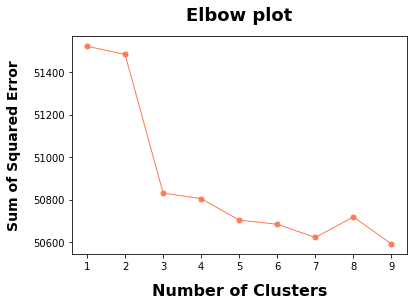

In [53]:
plt.plot(param, sse, color="#FF7B54", marker = '.', markersize=10, linewidth = 1)
plt.xlabel("Number of Clusters", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Sum of Squared Error", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Elbow plot", fontsize=18,pad=16, fontweight="bold")

In [54]:
optimal_k = 3
model = KMeans(n_clusters=optimal_k, init="k-means++", random_state=20, max_iter=2000, n_init=1)
y_predicted = model.fit_predict(tf_idf)
df["cluster"] = y_predicted
df['cluster'].value_counts()
df.head

0    33855
2    18492
1       65
Name: cluster, dtype: int64

<bound method NDFrame.head of       Unnamed: 0 comment_id comment_parent_id  \
0              0    iztdxuh         t3_zj2aeu   
1              1    iztn0q0         t3_zj2aeu   
2              2    izudrph         t3_zj2aeu   
3              3    iztfhtb         t3_zj2aeu   
4              4    izu2as9         t3_zj2aeu   
...          ...        ...               ...   
52410      16667    j4lbiix        t1_j4kgcac   
52411      16668    j5m0v6m        t3_10jmvpj   
52412      16669    j5m6aj0        t1_j5m0v6m   
52413      16670    j5nylax        t1_j5m0v6m   
52414      16671    j5mwpdr        t1_j5m6aj0   

                                            comment_body     subreddit  \
0      I've been shocked for days now, I don't need c...     r/ChatGPT   
1       \n\nI am so angry right now. I just wasted my...     r/ChatGPT   
2      chatgpt karma whoring is here folks! just when...     r/ChatGPT   
3                                     Worked on me, ngl.     r/ChatGPT   
4      Cert

In [55]:
print("Cluster Hotwords")
hotwords = model.cluster_centers_.argsort()[:, ::-1]
feature_names = vectorizer.get_feature_names()

for i in range(optimal_k):
    print(f"Cluster {i}")
    for j in hotwords[i, :20]:
        print(f"{feature_names[j]}")
    print("-------------------------")

Cluster Hotwords


C:\Users\erice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Cluster 0
delete
work
like
thank
people
think
make
good
say
remove
lol
time
mean
know
need
pay
try
right
yeah
yes
-------------------------
Cluster 1
lol
zzs
free plagiarism
free phrase
free phrase like
free phrase likely
free pick
free pick pineapples
free place
free place sweet
free plagiarism checker
free phone
free plan
free plan allow
free plane
free plane ticket
free play
free play chat
free phone number
free personal users
-------------------------
Cluster 2
chatgpt
use
ai
write
like
ask
make
think
know
google
answer
question
say
people
gpt
prompt
work
way
try
time
-------------------------


<AxesSubplot:>

Text(0.5, 0, 'Comment Cluster')

Text(0, 0.5, 'Number of Comments')

Text(0.5, 1.0, 'Clusterwise Data Frequency')

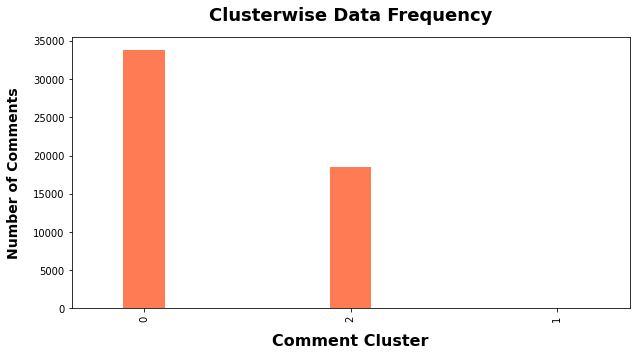

In [56]:
df['cluster'].value_counts().sort_values(ascending = False).plot(kind='bar', figsize=(10,5), width=0.2, color="#FF7B54")

plt.xlabel("Comment Cluster", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of Comments", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Clusterwise Data Frequency", fontsize=18,pad=16, fontweight="bold" )

plt.show()